In [1]:
'''
#Gigacow-tools# - data collection for fast/slow learner.
This scripts used for single cow data collection work.
Data Tables: gigacow_filter.csv, lactation_filter.csv, traffic_raw_filter.csv
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
pd.options.mode.chained_assignment = None
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.preprocessing import StandardScaler, OneHotEncoder

#access data from local directory
dataDir = Path.cwd().parent.parent/'Data/processed'
gigacow_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'BreedName', 'BirthDate']
lactation_cols = ['Gigacow_Cow_Id', 'FarmName_Pseudo', 'LactationInfoDate', 'LactationNumber', 'DaysInMilk']
gigacow = pd.read_csv(dataDir/'gigacow_filter.csv', encoding='utf-8', usecols=gigacow_cols)
lactation = pd.read_csv(dataDir/'lactation_filter.csv', encoding='utf-8', usecols=lactation_cols)
traffic = pd.read_csv(dataDir/'traffic_raw_filter.csv', encoding='utf-8', index_col=False)
#check out cows with most milking events
print(traffic.Gigacow_Cow_Id.value_counts().nlargest(10))

Gigacow_Cow_Id
5613    17247
4504    16330
5046    15623
5147    15440
3147    15303
478     14751
6380    14514
1181    14434
4478    14434
1985    14419
Name: count, dtype: int64


In [2]:
# Select cows with sufficient data points on single lactation periods
# Try to collect cow's data that contain milking events on lactation periods 1
# fetch all milking traffic events for merging
traffic_milking = traffic.TrafficResult.str.contains('kg', regex=False)
all_list = traffic_milking.index[traffic_milking.values == True].tolist()
milking_total = traffic[traffic.index.isin(all_list)]
milking_total.TrafficEventDateTime = pd.to_datetime(milking_total.TrafficEventDateTime)
milking_total['milking_date'] = milking_total.TrafficEventDateTime.dt.date

# convert data type
milking_total.milking_date = pd.to_datetime(milking_total.milking_date)
lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
# merge all milking events with lactation table for filtering
milking_total = milking_total.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'milking_date'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
def lac_collect(NumLac, milking_total):
    """Generate cow list for multiple lactation periods.

    Args:
        NumLac: The number of lactaion period
        milking_total: A dataframe contains all the milkings events

    Returns:
        A list contain all the cows events with sufficient data points within the lactation periods.
    """
    cow_list = list()
    for num in range(1, NumLac+1):
        # select records that contains lactation period #num
        milking_select1 = milking_total.loc[milking_total['LactationNumber'] == num]
        milking_select1.drop_duplicates(subset=['Gigacow_Cow_Id', 'milking_date', 'LactationNumber', 'DaysInMilk'], inplace=True)
        # drop the anomaly data point
        milking_select1 = milking_select1.loc[milking_select1.DaysInMilk < 400]
        # select sufficient data points on lactation
        selected1 = milking_select1.Gigacow_Cow_Id.value_counts(ascending=True)
        selected1 = selected1.loc[(selected1.values > 150) & (selected1.values < 365)]
        selected_cow_list = selected1.index.to_list()
        if num == 1:
            cow_list = selected_cow_list
        cow_list = list(set(cow_list) & set(selected_cow_list))
        print(len(cow_list), cow_list)
    return cow_list

cow_list = lac_collect(1, milking_total)

147 [2560, 3075, 2568, 2569, 4109, 3603, 1555, 6164, 5147, 3613, 3104, 1057, 544, 550, 5160, 2090, 4142, 48, 3638, 5691, 2112, 3657, 74, 3149, 6222, 1103, 4176, 2135, 1113, 6235, 603, 4704, 6241, 4195, 5225, 4714, 622, 5235, 5239, 3705, 4730, 3707, 645, 3206, 5767, 2694, 3718, 5262, 2702, 151, 6300, 4765, 1181, 5279, 3744, 4769, 2724, 1705, 6316, 3762, 5301, 182, 2742, 4280, 4792, 708, 4295, 5322, 2251, 1738, 1744, 5846, 4311, 1755, 1244, 5852, 2278, 2792, 6380, 3822, 5873, 2805, 5372, 1277, 769, 1796, 4871, 2844, 289, 6434, 4899, 6439, 4910, 1842, 1331, 6452, 2868, 3890, 1336, 6463, 2374, 6472, 4939, 2386, 855, 5465, 1905, 3446, 2423, 3447, 1910, 4990, 6018, 2956, 6039, 2460, 926, 3487, 5534, 2466, 2979, 4524, 4525, 4012, 943, 5555, 5046, 951, 1464, 4537, 1985, 961, 6086, 2510, 978, 5076, 2517, 985, 478, 5088, 5092, 3045, 2031, 5616, 6127, 2039, 2047]


In [3]:
def countCowAge(birthDate, milkingDate):
    '''
    func: Calculate cows age based on birthDate and milkingDate
    args: 
        birthDate: cow's birth datetime
        milkingDate: milking events datetime
    return: cow age in human years(float)
    '''
    birthDate = pd.to_datetime(birthDate)
    milkingDate = pd.to_datetime(milkingDate)
    days = np.float32(np.datetime64(milkingDate, 'D') - np.datetime64(birthDate, 'D'))
    age = np.around(days/365, 2)
    return age

# select single cow from the traffic table

def data_collector(traffic, gigacow, lactation, cow_id, lacNumList):
    '''
    func: collect features from for a single cow
    args: 
        traffic: traffic data table
        gigacow: gigacow data table
        lactation: lactation data table
        cow_id: gigacow_id of the cow
        lacNumList: a list lactation period number
    return: A dataframe contains all features for a single cow on specfic lactation period
    '''

    traffic_single_cow = traffic.loc[traffic['Gigacow_Cow_Id'] == cow_id]
    traffic_single_cow.sort_values(by='TrafficEventDateTime', inplace=True)
    traffic_single_cow.index = range(len(traffic_single_cow))

    '''
        Extract Milking Event and its most recent traffic event to calculate T2-T1
        T1: Entry time into the Mjolkfalla
        T2: Entry time into the milking robot
        T2-T1: calculate time difference between T2&T1 (i.e., Time spend in Mjolkfalla/holding area)
    '''
    # locate mikling event by searching 'kg' keyword in traffic result
    # the most recent traffic event to milking event should be pre_milking event
    # need to filter out records with gate failure
    track_milking = traffic_single_cow.TrafficResult.str.contains('kg', regex=False)
    milking_index_list = track_milking.index[track_milking.values == True].tolist()
    pre_milking_index_list = [x-1 for x in milking_index_list]
    milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(milking_index_list)]
    pre_milking_traffic = traffic_single_cow[traffic_single_cow.index.isin(pre_milking_index_list)]

    # drop rows that the gate failed to detect cows but have milking result
    # previous area in milking_traffic table should only be Mjolkfalla
    # previous area in pre_milking_traffic table should not be Mjolkfalla
    failed_list_1_milk = milking_traffic.index[milking_traffic['PreviousArea'] == 'Koridor till Sorteringsgrind 2'].tolist()
    failed_list_1_pre = [x-1 for x in failed_list_1_milk]
    failed_list_2_pre = pre_milking_traffic.index[pre_milking_traffic['PreviousArea'] == 'Mjolkfalla'].tolist()
    failed_list_2_milk = [x+1 for x in failed_list_2_pre]
    # traffic result in pre_milking_traffic table should contain Mjolkfalla
    track_pre_milking = pre_milking_traffic.TrafficResult.str.contains('Mjolkfalla', regex=False)
    failed_list_3_pre = track_pre_milking.index[track_pre_milking.values == False].tolist()
    failed_list_3_milk = [x+1 for x in failed_list_3_pre]

    # remove failed records based on index list
    milking_traffic_failed = failed_list_1_milk + failed_list_2_milk + failed_list_3_milk
    pre_milking_traffic_failed = failed_list_1_pre + failed_list_2_pre + failed_list_3_pre
    milking_traffic.drop(axis=0, index=milking_traffic_failed, inplace=True)
    pre_milking_traffic.drop(axis=0, index=pre_milking_traffic_failed, inplace=True)
    # concatenate two tables to track the traffic directly
    all_milking_traffic = pd.concat([milking_traffic, pre_milking_traffic])
    all_milking_traffic.sort_values(by=['TrafficEventDateTime'], inplace=True)
    #rename table columns for merging
    milking_traffic.rename(columns={"TrafficEventDateTime": "MilkingEventDateTime", "TrafficResult": "MilkProduction", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    pre_milking_traffic.rename(columns={"TrafficEventDateTime": "Pre_MilkingEventDateTime", "TimeInArea_totalSeconds": "RoundedSecondsTimeInArea"}, inplace=True)
    # unify the index of two tables
    milking_traffic.index = range(len(milking_traffic))
    pre_milking_traffic.index = range(len(pre_milking_traffic))
    # inert "pre_traffic_milking" to milking traffic table
    milking_traffic.insert(5, 'Pre_MilkingEventDateTime', pre_milking_traffic['Pre_MilkingEventDateTime'])
    # calculate T2-T1
    milking_traffic.MilkingEventDateTime = pd.to_datetime(milking_traffic.MilkingEventDateTime)
    milking_traffic.Pre_MilkingEventDateTime = pd.to_datetime(milking_traffic.Pre_MilkingEventDateTime)
    milking_traffic['timeDelta_Seconds'] = (milking_traffic['MilkingEventDateTime'] - milking_traffic['Pre_MilkingEventDateTime']).dt.total_seconds()

    # extract traffic result(milk production)
    milking_traffic['MilkProduction'].replace(r"[^0-9.,]+"," ", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"\s*","", inplace=True, regex=True)
    milking_traffic['MilkProduction'].replace(r"[,]+",".", inplace=True, regex=True)
    milking_traffic['MilkProduction'] = milking_traffic['MilkProduction'].astype('float64')

    # merge all the other features into milking_traffic table
    milking_traffic['MilkingDate'] = milking_traffic.MilkingEventDateTime.dt.date
    milking_traffic.MilkingDate = pd.to_datetime(milking_traffic.MilkingDate)
    lactation.LactationInfoDate = pd.to_datetime(lactation.LactationInfoDate)
    single_cow_merge = milking_traffic.merge(lactation, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'LactationInfoDate'])
    single_cow_merge = single_cow_merge.merge(gigacow, how='left', left_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'], right_on=['FarmName_Pseudo', 'Gigacow_Cow_Id'])

    # drop failed data points based on RoundedSecondsTimeInArea & timeDelta_Seconds
    single_cow_merge.drop(single_cow_merge.loc[abs(single_cow_merge.timeDelta_Seconds - single_cow_merge.RoundedSecondsTimeInArea) > 300].index, inplace=True)
    single_cow_merge['TrafficDeviceName'].replace(r"[A-Za-z]+\s*","vms", inplace=True, regex=True)
    # calculate age of cows
    single_cow_merge['Age'] = single_cow_merge.apply(lambda x: countCowAge(x['BirthDate'], x['MilkingEventDateTime']), axis=1)
    single_cow_merge.drop(['BirthDate'], axis=1, inplace=True)
    single_cow_merge.dropna(inplace=True)

    # integrate multiple milking events for a single DIM
    single_cow_merge = single_cow_merge[single_cow_merge.LactationNumber.isin(lacNumList)]
    single_cow_merge.index = range(1,len(single_cow_merge)+1) 
    single_cow_merge.drop(['MilkingEventDateTime', 'Pre_MilkingEventDateTime', 'Traffic_Id', 'MilkingInterval_totalSeconds', 'RoundedSecondsTimeInArea', 'PreviousArea', 'GroupName', 'LactationInfoDate', 'TrafficDeviceName'], axis=1, inplace=True)

    # uncomment following part to get combined milking events for each DIM
    # comb_cows = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).sum(['MilkProduction', 'timeDelta_Seconds'])
    # single_cow_merge_size = single_cow_merge.groupby(by=['FarmName_Pseudo', 'Gigacow_Cow_Id', 'MilkingDate', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age'], sort=False, as_index=False).size()
    # comb_cows = pd.concat([comb_cows, single_cow_merge_size['size']], axis=1, ignore_index=False)
    # comb_cows.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    # comb_cows.index = range(1, len(comb_cows)+1)
    # return comb_cows

    single_cow_merge.rename(columns={"MilkProduction": "Total_MilkProduction", "timeDelta_Seconds": "Total_timeDelta_Seconds", "size": "milking_times"}, inplace=True)
    single_cow_merge.index = range(1, len(single_cow_merge)+1)
    return single_cow_merge


In [4]:
"""
labeling cow with problematic/normal(1/0)
"""
threshold_ratio = 0.05
Path(dataDir/'Problematic_targetCows').mkdir(parents=True, exist_ok=True)
def labeling_problematic(threshold_ratio, cow_total): 
    '''
    func: labeling problematic cows
    args: 
        threshold_ratio: threshold ratio for the abnormal event milking events
        cow_total: A dataframe contains all data points for a single cow
    return: problematic cows dataset with label
    '''
    global learner
    total_events = len(cow_total)
    abnoramal_cows = cow_total.loc[cow_total.Total_timeDelta_Seconds > 7200]
    abnoramal_ratio = len(abnoramal_cows)/total_events
    print(abnoramal_ratio)
    if abnoramal_ratio > threshold_ratio:
        problematic = 1 # problematic cow
    else:
        problematic = 0 # normal cow
    cow_total['problematic'] = problematic
    return cow_total

In [5]:
# filter out cows' record start at the middle of the lactation
filter_list = []
for id in cow_list:
    single_cow = data_collector(traffic, gigacow, lactation, id, [1])
    if single_cow.DaysInMilk.min() < 60:
        filter_list.append(id)

print("filtered: ", len(filter_list), filter_list)

filtered:  142 [2560, 3075, 2568, 2569, 4109, 3603, 1555, 6164, 5147, 3613, 3104, 1057, 544, 550, 5160, 2090, 4142, 48, 3638, 5691, 2112, 3657, 74, 3149, 6222, 1103, 4176, 2135, 1113, 6235, 603, 4704, 6241, 4195, 5225, 4714, 5235, 5239, 3705, 4730, 3707, 645, 3206, 5767, 2694, 3718, 5262, 2702, 151, 6300, 4765, 1181, 5279, 3744, 4769, 2724, 1705, 6316, 5301, 2742, 4280, 4792, 708, 4295, 5322, 2251, 1738, 1744, 5846, 4311, 1755, 1244, 5852, 2278, 2792, 6380, 3822, 5873, 2805, 5372, 1277, 769, 1796, 4871, 2844, 289, 6434, 4899, 6439, 4910, 1842, 1331, 6452, 2868, 3890, 1336, 6463, 2374, 6472, 4939, 2386, 855, 5465, 1905, 3446, 2423, 3447, 1910, 4990, 6018, 2956, 6039, 2460, 926, 5534, 2466, 2979, 4524, 4525, 4012, 943, 5555, 5046, 951, 1464, 1985, 961, 6086, 2510, 978, 5076, 2517, 985, 478, 5088, 5092, 3045, 2031, 5616, 6127, 2039, 2047]


In [6]:
#Uses the labeling_problematic function to label problematic cows and print distribution of time into a PDF
from matplotlib.backends.backend_pdf import PdfPages
import warnings
pd.set_option('mode.chained_assignment', None)

""" plot the relations between timeDelta and Lactation/DIM(DaysInMilk)
        @@@ Total_timeDelta @@@
    """ 
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with PdfPages(dataDir/'100cows_timecost_scatters_lac1_with_label_scale30000.pdf') as pdf:
        for id in filter_list:
            print("cow_id:", id)
            single_cow_merge = data_collector(traffic, gigacow, lactation, id, [1])
            single_cow_merge = labeling_problematic(0.05, single_cow_merge)
            prob = single_cow_merge.problematic.unique()[0]
            fig1 = plt.figure()
            # fig2 = plt.figure()
            if prob == 1:
                title = "Problematic_Cow_cow_id_"+ str(id)
            else:
                title = "Normal_Cow_cow_id_"+ str(id)
            fig1 = single_cow_merge.loc[single_cow_merge.LactationNumber == 1].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='scatter', title=title+"_Lac1", xlim=[1, 360], ylim=[0, 30000], s=2, c='b')
            # fig2 = single_cow_merge.loc[single_cow_merge.LactationNumber == 2].plot(x="DaysInMilk", y="Total_timeDelta_Seconds", kind='scatter', title=title+"_Lac2", xlim=[1, 360], ylim=[0, 10000], s=2, c='b')
            pdf.savefig(fig1.get_figure())
            # pdf.savefig(fig2.get_figure())
            plt.close()

cow_id: 2560
0.003472222222222222
cow_id: 3075
0.0680379746835443
cow_id: 2568
0.14465408805031446
cow_id: 2569
0.0
cow_id: 4109
0.24615384615384617
cow_id: 3603
0.032362459546925564
cow_id: 1555
0.0017452006980802793
cow_id: 6164
0.17270788912579957
cow_id: 5147
0.0
cow_id: 3613
0.0
cow_id: 3104
0.01238390092879257
cow_id: 1057
0.01703800786369594
cow_id: 544
0.21496815286624205
cow_id: 550
0.05955678670360111
cow_id: 5160
0.004722550177095631
cow_id: 2090
0.003260869565217391
cow_id: 4142
0.09314586994727592
cow_id: 48
0.018907563025210083
cow_id: 3638
0.0027397260273972603
cow_id: 5691
0.4318181818181818
cow_id: 2112
0.013793103448275862
cow_id: 3657
0.09400544959128065
cow_id: 74
0.0026490066225165563
cow_id: 3149
0.017467248908296942
cow_id: 6222
0.039540816326530615
cow_id: 1103
0.0020408163265306124
cow_id: 4176
0.032577903682719546
cow_id: 2135
0.06801736613603473
cow_id: 1113
0.0074005550416281225
cow_id: 6235
0.27607361963190186
cow_id: 603
0.009497964721845319
cow_id: 4704
0

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
pd.options.mode.chained_assignment = None

mean_totalTimeCost = 0
Path(dataDir/'Problematic_targetCows').mkdir(parents=True, exist_ok=True)
lactationNum = [1]

# save a list of cow data for abnormal cows detection problem
for i, cow_id in enumerate(filter_list):
    single_cow_merge = data_collector(traffic, gigacow, lactation, cow_id, lactationNum)
    mean_totalTimeCost += single_cow_merge.Total_timeDelta_Seconds.mean()
    single_cow_merge = labeling_problematic(threshold_ratio, single_cow_merge)
    problematic = single_cow_merge.problematic.unique()[0]
    if problematic == 1:
        print("This cow is problematic")
    single_cow_merge["id"] = i+1
    single_cow_merge.dropna(inplace=True)
    fileName = 'Problematic_targetCows/cow_' + str(i) + '.csv'
    single_cow_merge.to_csv(dataDir/fileName)
print("num of cows: ", len(cow_list))
print("Mean of total time cost: ", mean_totalTimeCost/len(cow_list))

0.003472222222222222
0.0680379746835443
This cow is problematic
0.14465408805031446
This cow is problematic
0.0
0.24615384615384617
This cow is problematic
0.032362459546925564
0.0017452006980802793
0.17270788912579957
This cow is problematic
0.0
0.0
0.01238390092879257
0.01703800786369594
0.21496815286624205
This cow is problematic
0.05955678670360111
This cow is problematic
0.004722550177095631
0.003260869565217391
0.09314586994727592
This cow is problematic
0.018907563025210083
0.0027397260273972603
0.4318181818181818
This cow is problematic
0.013793103448275862
0.09400544959128065
This cow is problematic
0.0026490066225165563
0.017467248908296942
0.039540816326530615
0.0020408163265306124
0.032577903682719546
0.06801736613603473
This cow is problematic
0.0074005550416281225
0.27607361963190186
This cow is problematic
0.009497964721845319
0.03292181069958848
0.014245014245014245
0.00922266139657444
0.002044989775051125
0.03800475059382423
0.017857142857142856
0.02361111111111111
0.0

In [8]:
""" Data Preparation """

usecols = ['id', 'FarmName_Pseudo', 'Gigacow_Cow_Id', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'LactationNumber', 'DaysInMilk', 'BreedName', 'Age', 'MilkingDate', 'problematic']
dataDir = Path.cwd().parent.parent/'Data/processed/Problematic_targetCows/'

# integrate all the cows data into one dataset
filelist = list(Path(dataDir).glob('cow_*.csv'))
for i, _ in enumerate(filelist):
    fileName = 'cow_' + str(i) + '.csv'
    single_cow = pd.read_csv(dataDir/fileName, encoding='utf-8', usecols=usecols)
    single_cow.sort_values(by=['MilkingDate'], inplace=True)
    if i == 0:
        cow_total = single_cow
    else:
        cow_total = pd.concat([cow_total, single_cow], axis=0, ignore_index=True)
cow_total.to_csv(dataDir.parent/"Cow_Prob_dataset_L1.csv", index=False)
cow_total

,FarmName_Pseudo,Gigacow_Cow_Id,Total_MilkProduction,Total_timeDelta_Seconds,MilkingDate,LactationNumber,DaysInMilk,BreedName,Age,problematic,id
0,a624fb9a,2560,9.38,3176.0,2022-02-14,1.0,2.0,1,2.15,0,1
1,a624fb9a,2560,8.46,352.0,2022-02-14,1.0,2.0,1,2.15,0,1
2,a624fb9a,2560,6.68,997.0,2022-02-15,1.0,3.0,1,2.15,0,1
3,a624fb9a,2560,7.34,9274.0,2022-02-15,1.0,3.0,1,2.15,0,1
4,a624fb9a,2560,8.15,407.0,2022-02-16,1.0,4.0,1,2.15,0,1
...,...,...,...,...,...,...,...,...,...,...,...
95849,a624fb9a,2047,7.96,59.0,2022-11-12,1.0,322.0,1,3.02,0,142
95850,a624fb9a,2047,5.53,148.0,2022-11-13,1.0,323.0,1,3.03,0,142
95851,a624fb9a,2047,3.24,287.0,2022-11-13,1.0,323.0,1,3.03,0,142
95852,a624fb9a,2047,9.23,240.0,2022-11-13,1.0,323.0,1,3.03,0,142


In [22]:
#df_static_features = cow_total[['FarmName_Pseudo']]
static_cols = ['FarmName_Pseudo', 'TrafficDeviceName', 'LactationNumber', 'BreedName']
timeSeries_cols = ['Age', 'Total_MilkProduction', 'Total_timeDelta_Seconds', 'DaysInMilk']
output_col = ['problematic']

cow_label = cow_total[['id', 'problematic']].copy()
cow_timeseries = cow_total[['id', 'MilkingDate']].copy()
cow_timeseries.index = range(len(cow_timeseries))
# fetch y for feature extraction
y = cow_label.drop_duplicates(subset=['id'])
y = y["problematic"]
y.index = range(1,len(y)+1) 
print(y.value_counts())

problematic
0    97
1    45
Name: count, dtype: int64


In [23]:
# Prepare datasert for Tsfresh extraction
ts_extracted_dataset = cow_total[['id']].copy()
ts_extracted_dataset.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_dataset.index = range(1, len(ts_extracted_dataset)+1)
ts_processed = pd.DataFrame(cow_total[timeSeries_cols].copy())
ts_processed.index = range(0,len(ts_processed)) 
ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
ts_processed

,id,MilkingDate,Age,Total_MilkProduction,Total_timeDelta_Seconds,DaysInMilk
0,1,2022-02-14,2.15,9.38,3176.0,2.0
1,1,2022-02-14,2.15,8.46,352.0,2.0
2,1,2022-02-15,2.15,6.68,997.0,3.0
3,1,2022-02-15,2.15,7.34,9274.0,3.0
4,1,2022-02-16,2.15,8.15,407.0,4.0
...,...,...,...,...,...,...
95849,142,2022-11-12,3.02,7.96,59.0,322.0
95850,142,2022-11-13,3.03,5.53,148.0,323.0
95851,142,2022-11-13,3.03,3.24,287.0,323.0
95852,142,2022-11-13,3.03,9.23,240.0,323.0


In [24]:
settings_1 = MinimalFCParameters() 
#settings_2 = ComprehensiveFCParameters

for i, col in enumerate(timeSeries_cols):
    ts_processed = pd.DataFrame(cow_total[col].copy())
    ts_processed.index = range(0,len(ts_processed)) 
    ts_processed = pd.concat([cow_timeseries, ts_processed], axis=1)
    print(ts_processed)
    # extract time series features
    extracted_features = extract_features(ts_processed, column_id="id", column_sort="MilkingDate", default_fc_parameters=settings_1)
    #extracted_features.dropna(axis=1, inplace=True)
    impute(extracted_features)
    
    # select most relevant features based on relevance table
    if i == 0:
        temp = calculate_relevance_table(extracted_features, y)
        relevance_table = temp
    else:
        temp = calculate_relevance_table(extracted_features, y)
        relevance_table = pd.concat([relevance_table, temp], axis=0)
    features_filtered = select_features(extracted_features, y)
    ts_extracted_dataset = pd.concat([ts_extracted_dataset, features_filtered], axis=1)

# Select relevant features from the relevance table
relevance_table = relevance_table[relevance_table.relevant]
relevance_table.sort_values("p_value", ascending=False, inplace=True)
relevant_features_list = list(relevance_table.feature[:])
print(relevance_table)

ts_extracted_dataset_filtered = ts_extracted_dataset[relevant_features_list].copy()
ts_extracted_dataset_filtered = ts_extracted_dataset_filtered.loc[:,~ts_extracted_dataset_filtered.columns.duplicated()]
ts_extracted_dataset = ts_extracted_dataset_filtered
ts_extracted_dataset
ts_extracted_dataset.to_csv(dataDir/"problematic_cows_7200s_5percent_extracted_features.csv", index=False)
relevance_table.to_csv(dataDir/"problematic_cows_7200s_5percent_relevance_table.csv")

        id MilkingDate   Age
0        1  2022-02-14  2.15
1        1  2022-02-14  2.15
2        1  2022-02-15  2.15
3        1  2022-02-15  2.15
4        1  2022-02-16  2.15
...    ...         ...   ...
95849  142  2022-11-12  3.02
95850  142  2022-11-13  3.03
95851  142  2022-11-13  3.03
95852  142  2022-11-13  3.03
95853  142  2022-11-14  3.03

[95854 rows x 3 columns]


Feature Extraction: 100%|██████████| 36/36 [00:02<00:00, 17.66it/s]


        id MilkingDate  Total_MilkProduction
0        1  2022-02-14                  9.38
1        1  2022-02-14                  8.46
2        1  2022-02-15                  6.68
3        1  2022-02-15                  7.34
4        1  2022-02-16                  8.15
...    ...         ...                   ...
95849  142  2022-11-12                  7.96
95850  142  2022-11-13                  5.53
95851  142  2022-11-13                  3.24
95852  142  2022-11-13                  9.23
95853  142  2022-11-14                  7.42

[95854 rows x 3 columns]


Feature Extraction: 100%|██████████| 36/36 [00:02<00:00, 17.65it/s]


        id MilkingDate  Total_timeDelta_Seconds
0        1  2022-02-14                   3176.0
1        1  2022-02-14                    352.0
2        1  2022-02-15                    997.0
3        1  2022-02-15                   9274.0
4        1  2022-02-16                    407.0
...    ...         ...                      ...
95849  142  2022-11-12                     59.0
95850  142  2022-11-13                    148.0
95851  142  2022-11-13                    287.0
95852  142  2022-11-13                    240.0
95853  142  2022-11-14                     10.0

[95854 rows x 3 columns]


Feature Extraction: 100%|██████████| 36/36 [00:02<00:00, 15.57it/s]


        id MilkingDate  DaysInMilk
0        1  2022-02-14         2.0
1        1  2022-02-14         2.0
2        1  2022-02-15         3.0
3        1  2022-02-15         3.0
4        1  2022-02-16         4.0
...    ...         ...         ...
95849  142  2022-11-12       322.0
95850  142  2022-11-13       323.0
95851  142  2022-11-13       323.0
95852  142  2022-11-13       323.0
95853  142  2022-11-14       324.0

[95854 rows x 3 columns]


Feature Extraction: 100%|██████████| 36/36 [00:02<00:00, 16.05it/s]


                                                                                 feature  \
feature                                                                                    
DaysInMilk__sum_values                                            DaysInMilk__sum_values   
Total_MilkProduction__maximum                              Total_MilkProduction__maximum   
Total_MilkProduction__absolute_maximum            Total_MilkProduction__absolute_maximum   
DaysInMilk__minimum                                                  DaysInMilk__minimum   
Total_MilkProduction__minimum                              Total_MilkProduction__minimum   
Total_MilkProduction__standard_deviation        Total_MilkProduction__standard_deviation   
Total_MilkProduction__variance                            Total_MilkProduction__variance   
Age__sum_values                                                          Age__sum_values   
Total_MilkProduction__mean                                    Total_MilkProducti

In [25]:
# Construct extracted training data
ts_extracted_id = cow_total[['id']].copy()
ts_extracted_id.drop_duplicates(subset=['id'], inplace=True)
ts_extracted_id.index = range(1, len(ts_extracted_id)+1)
ts_extracted_dataset = pd.concat([ts_extracted_id, ts_extracted_dataset], axis=1)

ts_extracted_features = ts_extracted_dataset.iloc[:, 1:len(ts_extracted_dataset.columns)].copy()
# normalize numerical features
ts_extracted_cols = ts_extracted_features.columns
scaler_std = StandardScaler()
ts_std = scaler_std.fit_transform(ts_extracted_features)
# transform standard data into dataframe
ts_extracted_processed = pd.DataFrame(ts_std, columns=ts_extracted_cols)
ts_extracted_processed.index = range(1,len(ts_extracted_processed)+1)
# append id col to the dataframe
ts_extracted_processed = pd.concat([ts_extracted_dataset['id'], ts_extracted_processed], axis=1)

# One-Hot encoding categorical feature - BreedName
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)
cow_breed = cow_total[['id', 'BreedName']].copy()
cow_breed.drop_duplicates(subset=['id'], inplace=True)
cat = ohe.fit_transform(np.array(cow_breed['BreedName']).reshape(-1, 1))
col_names = ohe.get_feature_names_out(['BreedName'])
cat_breed = pd.DataFrame(cat, columns=col_names)
cat_breed.index = range(1,len(cow_breed)+1)

# append features on extracted dataset
ts_dataset = pd.concat([ts_extracted_processed, cat_breed], axis=1)
ts_dataset = pd.concat([ts_dataset, y], axis=1)
ts_dataset.to_csv(dataDir/"problematic_100cows_7200s_5percent_features.csv", index=False)
ts_dataset

C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,id,DaysInMilk__sum_values,Total_MilkProduction__maximum,Total_MilkProduction__absolute_maximum,DaysInMilk__minimum,Total_MilkProduction__minimum,Total_MilkProduction__standard_deviation,Total_MilkProduction__variance,Age__sum_values,Total_MilkProduction__mean,...,Total_timeDelta_Seconds__median,Total_timeDelta_Seconds__standard_deviation,Total_timeDelta_Seconds__variance,Total_timeDelta_Seconds__mean,Total_timeDelta_Seconds__root_mean_square,BreedName_1,BreedName_2,BreedName_4,BreedName_99,problematic
1,1,0.041416,-0.606249,-0.606249,-0.515465,-0.485766,-0.870912,-0.794164,0.682971,-0.743696,...,-0.713234,-0.800136,-0.517272,-0.773052,-0.797385,1.0,0.0,0.0,0.0,0
2,2,-0.127943,-0.830462,-0.830462,0.671497,-0.081988,-0.697685,-0.673874,-0.355900,-0.524190,...,-0.198049,1.177999,0.733017,0.232248,0.851429,0.0,1.0,0.0,0.0,1
3,3,-0.667363,0.433045,0.433045,-0.317638,-0.135825,1.468895,1.427846,-0.826430,0.562645,...,1.048832,2.102698,1.856869,1.397014,1.842398,0.0,0.0,0.0,1.0,1
4,4,0.259103,-0.550855,-0.550855,0.374757,-0.115636,-1.411532,-1.124109,0.258860,-0.287375,...,-0.814724,-1.162137,-0.575848,-1.031936,-1.121810,1.0,0.0,0.0,0.0,0
5,5,-0.624533,0.546471,0.546471,-0.119811,1.176455,-0.153387,-0.249899,-1.314833,0.457778,...,1.562084,2.195322,1.988376,2.140811,2.181163,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,138,-0.252569,-0.318728,-0.318728,2.946508,-0.357903,-0.432186,-0.475787,-1.172580,-1.159289,...,-0.435343,-0.733957,-0.500869,-0.580319,-0.681305,0.0,1.0,0.0,0.0,0
139,139,-0.002871,0.195643,0.195643,-0.614378,-0.613629,-0.298367,-0.369650,0.305279,-0.065207,...,-0.455641,-0.234920,-0.320502,-0.229227,-0.238628,0.0,1.0,0.0,0.0,0
140,140,0.252865,-0.060224,-0.060224,-0.416551,-0.391551,-0.873061,-0.795612,0.617516,-0.324087,...,-0.672637,-0.559973,-0.449351,-0.602978,-0.582368,1.0,0.0,0.0,0.0,0
141,141,0.034215,1.016000,1.016000,0.275843,3.175158,-0.100269,-0.204785,-0.112157,0.646637,...,-0.356567,-0.382108,-0.384107,-0.413825,-0.400397,1.0,0.0,0.0,0.0,0


In [26]:
"""Implementation on Gaussian Process Classifier"""

import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
pd.options.mode.chained_assignment = None

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared
grid = dict()
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


dataDir = Path.cwd().parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"problematic_100cows_7200s_5percent.csv", index_col="id")

In [27]:
X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=86)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\l

Mean cross-validated score of the best_estimator:  0.966256157635468
Best estimator parameters:  {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.961 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.962 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.891 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.966 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.891 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy 0.923 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [28]:
search.best_params_

{'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}

In [29]:
y_train.value_counts()

problematic
0              73
1              33
Name: count, dtype: int64

In [30]:
y_test.value_counts()

problematic
0              24
1              12
Name: count, dtype: int64

In [31]:
# best_kernel = 1*DotProduct()
# best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)
# best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
# best_kernel = 1**2 * RBF(length_scale=1)
model = GaussianProcessClassifier(kernel=best_kernel, random_state=30, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  1.0
Prediction on test data:  [1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1]
Prediction accuracy on test data:  0.9722222222222222


C:\Users\tokm0001\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [32]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.37185235, 0.62814765],
       [0.4064951 , 0.5935049 ],
       [0.86770898, 0.13229102],
       [0.05025946, 0.94974054],
       [0.84716531, 0.15283469],
       [0.82723157, 0.17276843],
       [0.11689736, 0.88310264],
       [0.77017023, 0.22982977],
       [0.94315655, 0.05684345],
       [0.95584687, 0.04415313],
       [0.03257254, 0.96742746],
       [0.47979117, 0.52020883],
       [0.3390078 , 0.6609922 ],
       [0.93524286, 0.06475714],
       [0.90258323, 0.09741677],
       [0.93465881, 0.06534119],
       [0.04704377, 0.95295623],
       [0.78907209, 0.21092791],
       [0.27084476, 0.72915524],
       [0.95894809, 0.04105191],
       [0.91339589, 0.08660411],
       [0.97025945, 0.02974055],
       [0.98567672, 0.01432328],
       [0.96423458, 0.03576542],
       [0.95183931, 0.04816069],
       [0.05490722, 0.94509278],
       [0.93422476, 0.06577524],
       [0.96227879, 0.03772121],
       [0.04999278, 0.95000722],
       [0.93382346, 0.06617654],
       [0.

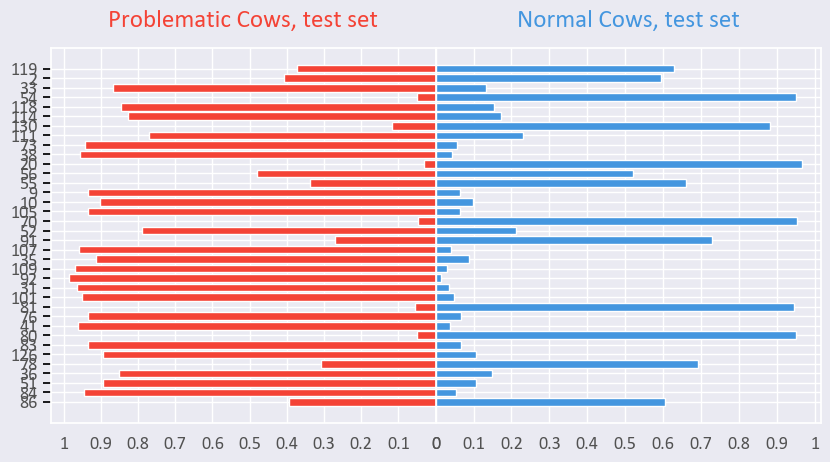

In [33]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#f44336'
color_blue = '#4496df'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Problematic Cows, test set'
title1 = 'Normal Cows, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'Problematic_Cows'
plt.savefig(filename+'.png', facecolor=facecolor)